![MIoT_GDPI](img/MIOT_GDPI_header.png)

# Unidad 06 - Autoencoders para la detección de anomalías en series temporales

En el desarrollo de modelos de aprendizaje automático para líneas de producción industriales, la detección de anomalías es clave y tiene un impacto transversal en las diferentes etapas de la vida de los modelos. Implementar sistemas robustos de detección de anomalías nos permitirá, en primer lugar, filtrar el conjunto de datos de entrenamiento, eliminando observaciones erróneas que podrían sesgar el aprendizaje del modelo y mermar su capacidad de generalización. En segundo lugar, una vez el modelo está desplegado en producción, la detección de anomalías actúa como un vigilante, filtrando los datos de entrada en tiempo real para identificar comportamientos inesperados o fallos en la maquinaria, previniendo así predicciones erróneas del modelo (o con mucha incertidumbre) y posibles fallos posteriores en el sistema de control, debido a las malas predicciones,  que podrían llevar a paradas de producción o productos defectuosos. Finalmente, en escenarios donde se emplean modelos de aprendizaje automático *online*, que se reentrenan continuamente con nuevos datos, la detección de anomalías es crucial para filtrar el flujo de datos de entrenamiento en tiempo real, garantizando que el modelo aprenda de información válida y relevante, manteniendo así su precisión y adaptabilidad a las condiciones cambiantes de la planta.

La detección de anomalías es compleja en cualquier campo pero destaca especialmente en la Industria por el gran número de variables y casuísticas posibles.  En esta práctica veremos como los  **autoencoders** pueden aprender el comportamiento "normal" de las plantas industriales analizando y entrenando con datos históricos y así "marcar" las observaciones "diferentes" en tiempo de producción.


El contenido de este Notebook está dedicado a explicar un ejemplo de detección de anomalías en series temporales empleando *autoencoders*.
Os invitamos a experimentar modificando y variando el código proporcionado para que podáis explorar las distintas opciones y profundizar en cada uno de los conceptos mostrados.

**Importante**: Este Notebook NO contiene ejercicios para entregar. 


## Referencias útiles para la práctica
1. A. Bosch Rué, J. Casas-Roma, T. Lozano Bagén (2019): [Deep learning : principios y fundamentos](https://elibro-net.ezbusc.usc.gal/es/ereader/busc/126167/).
2. Ejemplo Keras: [Timeseries anomaly detection using an Autoencoder](https://keras.io/examples/timeseries/timeseries_anomaly_detection/)


## Introducción a los autoencoders
Los *autoencoders* son un tipo de ANN cuyo objetivo es reproducir los datos de entrada de la red en su salida.  Están formados por dos partes principales: un **codificador** que mapea unas entradas a una representación interna, llamada **código latente** (que se encuentra en el **espacio latente**), y un  **decodificador** que reconstruye las entradas desde el código latente. 



Aunque en principio podríamos pensar que el proceso de reconstruir las entradas de una red no tiene utilidad, la realidad es que esta arquitectura nos permite entrenar una ANN para que aprenda las características más importantes y los patrones inherentes de los datos de entrada y esto lo hace útil para realizar tareas muy interesantes como:

* Reducción de dimensionalidad.
* Eliminación del ruido de los datos.
* **Detección de anomalías**.
* Generación de nuevos datos sintéticos
* etc.




<div style="text-align: center;">
<img src="img/Autoencoder_schema.png" width="300"/>
    <p style="text-align:center; font-style:italic;">Esquema simple de un autoencoder. Fuente Wikipedia. By Michela Massi - Own work, CC BY-SA 4.0</p>
</div>



Los *autoencoders* son ANN del tipo *feedforward* y *fully-connected* con varias características que las diferencian respecto a las ANN "normales":
* Los *autoencoders* tienen el mismo número de neuronas de entrada que de salida, ya que su objetivo es reconstruir las *inputs*.
* Las capas ocultas deben tener un número menor de neuronas que las capas de entrada y salida, ya que si no la tarea de reconstruir los datos sería trivial. La representación interna debe preservar la información de entrada en un formato de **menor dimensionalidad**.

La mayoría de los conceptos típicos asociados a las redes del tipo *feedforward* y *fully-connected*  (inicialización, entrenamiento, regularización, etc.), son de aplicación en los *autoencoders*.




<div style="text-align: center;">
<img src="img/autoencoder_architecture.png" width="500"/>
    <p style="text-align:center; font-style:italic;">Arquitectura de un autoencoder. Fuente: https://www.assemblyai.com/blog/introduction-to-variational-autoencoders-using-keras</p>
</div>



In [1]:
# import generales
try:
    import pandas as pd
except ImportError as err:
    !pip install pandas
    import pandas as pd

try:
    import numpy as np
except ImportError as err:
    !pip install numpy
    import numpy as np




try:
    import matplotlib.pyplot as plt
except ImportError as err:
    !pip install matplotlib
    import matplotlib.pyplot as plt

import os

# Asegurarnos de usar Keras 3 con backend TensorFlow
# Es necesario hacerlo antes de cargar Keras
os.environ["KERAS_BACKEND"] = "tensorflow"

# Importaciones de Keras y TensorFlow
try:
    import keras
except ImportError as err:
    !pip install keras
    import keras

try:
    import tensorflow as tf 
except ImportError as err:
    !pip install tensorflow
    import tensorflow as tf 


#simplemente por comodidad a la hora de crear los modelos
from keras.layers import GRU, TimeDistributed,RepeatVector,Input, Dense, LSTM

2025-06-02 14:42:33.464319: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 14:42:33.470612: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-02 14:42:33.512610: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-02 14:42:33.543755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748868153.573599    9262 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748868153.58

## Dataset sintético

Con el objetivo de probar un detector de anomalías basado en un *autoencoder*, hemos preparado un dataset sintético que simula, de forma muy básica, un sistema de secado de fibra en una línea de producción de tableros MDF.

En este proceso de secado, la fibra pasa por una cinta transportadora. En un punto de esta cinta se mide con un sensor NIR la humedad de entrada al proceso de la fibra y, en un punto posterior, se mide la temperatura de los gases empleados  para secarla (los valores de temperatura están en un rango entre 120° y 200°). En la salida del proceso de secado, existe otro  sensor NIR que mide la humedad resultante de la fibra. 

En este ejemplo tan sencillo, el valor resultante de humedad tiene una  relación directa con la humedad de entrada y la temperatura de los gases pero es importante tener en cuenta que la capacidad de secado de los gases no es lineal.

Las observaciones de nuestra línea de producción se toman cada segundo y son "fotos fijas" del proceso sin alinear, es decir, en cada instante $t$ se miden los valores de todos los sensores desplegados en la línea (3 en nuestro caso). Esta es la forma típica de trabajar en una planta y tiene como consecuencia que los valores de humedad de salida en el instante $t$ tienen relación con los valores de temperatura de los gases en el instante $t-n$ y con los valores de humedad de entrada en el instante $t-m$, siendo $m<n$. Debido a esta casuística, necesitamos **trabajar con secuencias de datos** para "recordar" el pasado. Es importante mencionar que los *autoencoders* pueden emplearse también con redes recurrentes (RNNs).



En este tipo de procesos, es habitual que alguno de los sensores (ej. sensor de humedad NIR para la humedad de entrada) se deterioren y generen datos anómalos. Las anomalías más típicas en un sensor de este tipo son:
1. El sensor queda bloqueado en alguna medida de humedad.
2. El sensor mide con un *bias* incrementando o decrementando el valor de humedad, respecto a la realidad.

En nuestro dataset hemos generado datos "normales" presentes en el fichero *train\_without\_anomaly.csv* y datos de test (*test\_without\_anomaly.csv*) a los que hemos introducido, en el sensor que mide la humedad de entrada, anomalías de los dos tipos previamente descritos (*test\_with\_anomaly.csv*).
Es importante destacar que, aunque el sensor tenga medidas anómalas, el proceso funciona correctamente, es decir, la humedad de salida tendrá una relación directa con la humedad de entrada real y la temperatura de los gases. El "problema" es que desconocemos la humedad de entrada real, ya que el sensor lo mide incorrectamente.


## Objetivo
Nuestro objetivo es analizar las secuencias de datos formadas por los 3 sensores (humedad de entrada, temperatura de gases y humedad de salida) y destacar las secuencias anómalas, es decir, las secuencias que no tienen el comportamiento esperado, ya que sus 3 medidas no están "armonizadas".

**Nota**: los problemas asociados a los *autoencoders* se consideran no supervisados, ya que no tenemos etiquetas externas describiendo que es cada observación.




## Carga de los datos desde el repositorio


In [2]:
## Carga de los datos
trainset=pd.read_csv("./datasets/train_without_anomaly.csv")
testset_sin_anomalias=pd.read_csv("./datasets/test_without_anomaly.csv")#solo para visualización
testset=pd.read_csv("./datasets/test_with_anomaly.csv")

In [3]:
##Vemos como son los datos cargados

print("Datos de entrenamiento:")
print(trainset.head())


##Los datos de test tienen una columna que marca los datos anómalos para poder comparar los resultados con la realidad
## Normalmente es dificil tener un dataset bien etiquetado de anomalías, ya que, en general, cuándo aparecen
print("Datos de test:")
print(testset.head())

Datos de entrenamiento:
   Sensor1_HumedadEntrada  Sensor2_TemperaturaGases  Output_HumedadSalida
0                0.775731                156.917438              0.077245
1                0.812161                148.645725              0.061767
2                0.738365                140.334998              0.096976
3                0.681176                142.090015              0.300313
4                0.699174                148.634488              0.432266
Datos de test:
   Sensor1_HumedadEntrada  Sensor2_TemperaturaGases  Output_HumedadSalida  \
0                0.815679                160.875974              0.074051   
1                0.784431                149.033159              0.066119   
2                0.764329                142.087646              0.109464   
3                0.705300                142.220004              0.211212   
4                0.634251                146.115705              0.456451   

   Es_Anomalia  
0        False  
1        False  
2  

### Visualización de los datos de entrenamiento
Generamos un *plot* de las primeras 500 observaciones del dataset para cada uno de los 3 sensores.

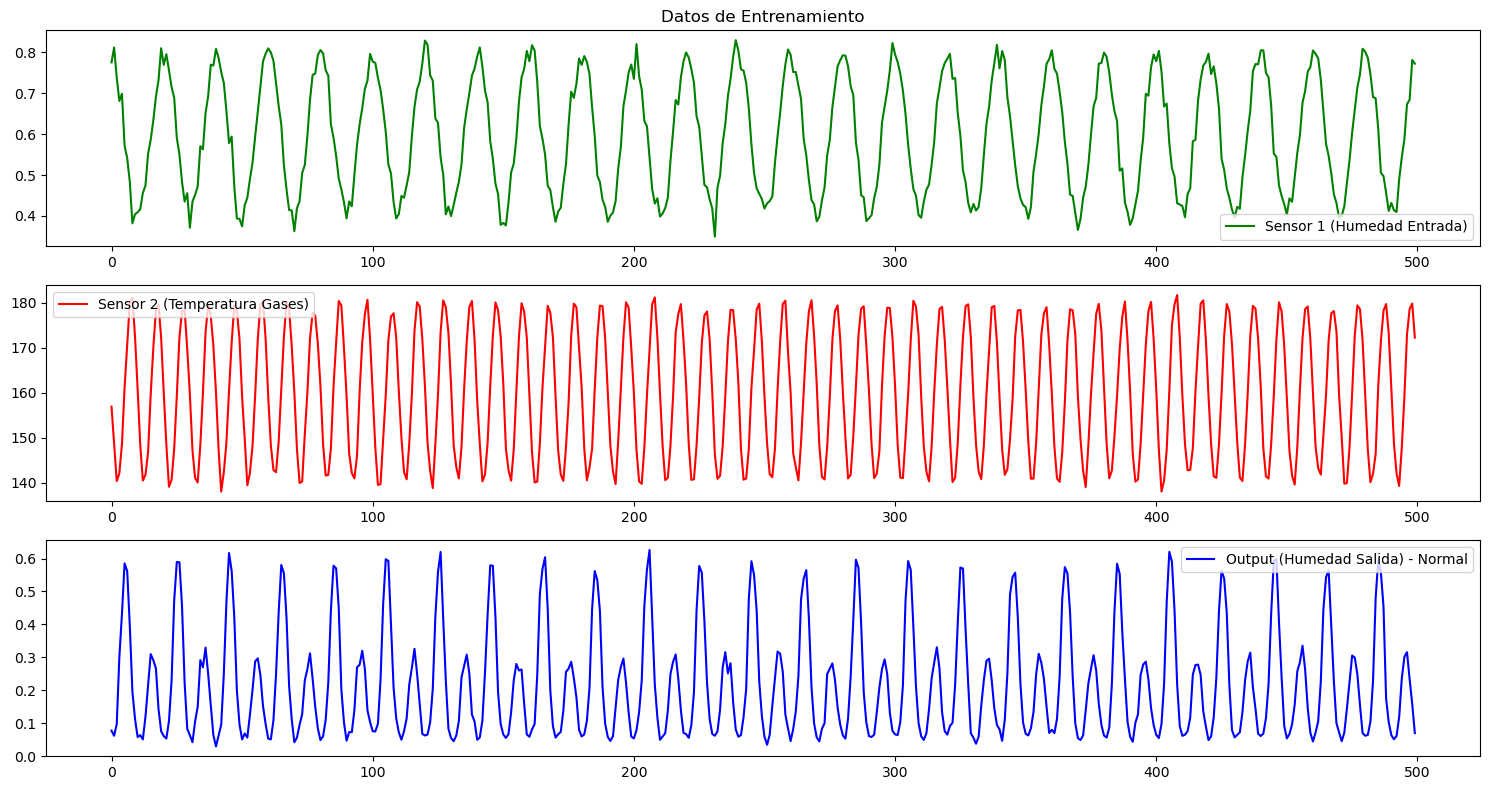

In [4]:
# Visualizar datos de entrenamiento (sensores y salida)
plt.figure(figsize=(15, 8))
plt.subplot(3,1,1)
plt.plot(trainset['Sensor1_HumedadEntrada'][:500], label='Sensor 1 (Humedad Entrada)',color='green')
plt.title('Datos de Entrenamiento')
plt.legend()
plt.subplot(3,1,2)
plt.plot(trainset['Sensor2_TemperaturaGases'][:500], label='Sensor 2 (Temperatura Gases)', color='red')
plt.legend()
plt.subplot(3,1,3)
plt.plot(trainset['Output_HumedadSalida'][:500], label='Output (Humedad Salida) - Normal', color='blue')
plt.legend()
plt.tight_layout()
plt.show()

### Visualización de los datos de Test

Generamos un *plot* con los datos de test. En este ejemplo tan sencillo, tenemos información de cómo deberían ser las secuencias de datos sin anomalías y cuáles son los períodos de tiempo anómalos.
La primera anomalía del sensor de humedad entrante, representa un sensor bloqueado. La segunda anomalía representa un *bias* en las medidas generadas por el sensor.

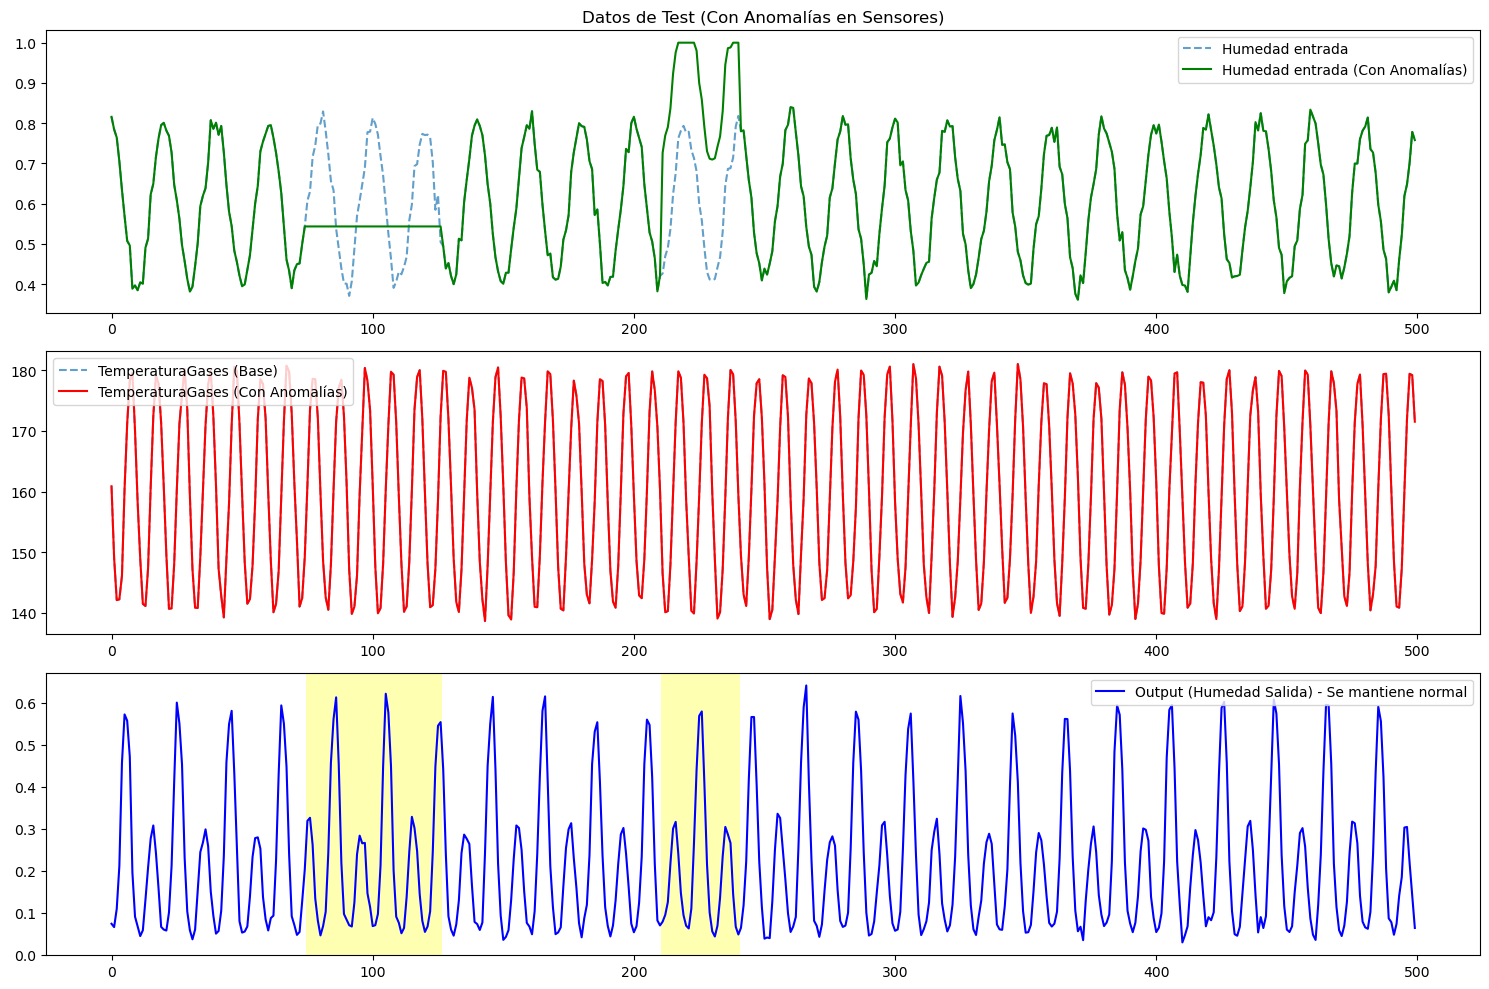

In [7]:
# Visualizar datos de test (con anomalías en sensores vs salida normal)
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
plt.plot(testset_sin_anomalias['Sensor1_HumedadEntrada'], label='Humedad entrada ', linestyle='--', alpha=0.7)
plt.plot(testset['Sensor1_HumedadEntrada'], label='Humedad entrada (Con Anomalías)', color='green')
plt.title('Datos de Test (Con Anomalías en Sensores)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(testset_sin_anomalias['Sensor2_TemperaturaGases'], label='TemperaturaGases (Base)', linestyle='--', alpha=0.7)
plt.plot(testset['Sensor2_TemperaturaGases'], label='TemperaturaGases (Con Anomalías)', color='red')
plt.legend()

plt.subplot(3,1,3)
plt.plot(testset['Output_HumedadSalida'], label='Output (Humedad Salida) - Se mantiene normal', color='blue')
# Marcar zonas de anomalía para referencia visual
anomaly_zones = testset[testset['Es_Anomalia']].index
for idx in anomaly_zones:
    plt.axvspan(idx - 0.5, idx + 0.5, color='yellow', alpha=0.3, lw=0)
plt.legend()
plt.tight_layout()
plt.show()

## Preprocesado de datos

En este ejemplo tan sencillo solo realizaremos la estandarización de los datos y lo haremos, en este caso, de forma manual. 

Dado que no vamos a optimizar hiperparámetros, no emplearemos el conjunto de validación, aunque dejaremos un pequeño porcentaje durante el entrenamiento dedicado a "parar" el entrenamiento para evitar el sobreentrenamiento (*early stop*).


In [8]:
# Obtenemos la media y la desviación típica.
training_mean = trainset.mean()
training_std = trainset.std()
scaled_trainset=(trainset - training_mean) / training_std
scaled_testset=(testset- training_mean) / training_std



## Preparación de las secuencias


En nuestro caso de uso necesitamos procesar secuencias temporales, ya que la salida está influenciada por las medidas de los sensores en los pasos anteriores. Vamos a generar secuencias con solape, para que el autoencoder aprenda el comportamiento "normal".

Las secuencias en este caso son un poco diferentes a lo que normalmente estamos acostumbrados, ya que estamos trabajando en un problema no etiquetado. Lo que buscamos es reproducir las secuencias de entrada, por lo que  las *inputs* y las *outputs* serán las mismas y las dos serán secuencias. En este caso no podemos emplear la librería de Keras que nos ayudaba a generar secuencias (`keras.utils.timeseries_dataset_from_array`), ya que no permite asociar a los *targets* secuencias. Crearemos, por lo tanto, una pequeña función que nos ayude a procesar las secuencias de la forma correcta.


In [9]:
#no podemos emplear keras.utils.timeseries_dataset_from_array porque no genera secuencias para la salida (targets)
WINDOW_SIZE=10 #tamaño de la secuencia que queremos generar. En principio el tamaño necesario de la secuencia no es conocido
NUM_INPUTS=3 #Numero de características: sensor humedad de entrada, temperatura de gases, sensor humedad de salida

def crear_secuencias(data, window_size):
    X = []
    for i in range(len(data) - window_size + 1):
        X.append(data[i:(i + window_size)])
    return np.array(X)

# Crear secuencias para entrenamiento y test
# El autoencoder intentará reconstruir la secuencia completa
X_train_seq = crear_secuencias(scaled_trainset, WINDOW_SIZE)
X_test_seq = crear_secuencias(scaled_testset[["Sensor1_HumedadEntrada","Sensor2_TemperaturaGases","Output_HumedadSalida"]], WINDOW_SIZE)#quito la etiqueta de anomalia que es solo para visualización

print("Forma de secuencias de entrenamiento:", X_train_seq.shape) # (samples, window_size, n_features)
print("Forma de secuencias de test:", X_test_seq.shape)

#visualizamos una secuencia
print(X_train_seq[0])

Forma de secuencias de entrenamiento: (2991, 10, 3)
Forma de secuencias de test: (491, 10, 3)
[[ 1.23160491 -0.21859254 -0.86768126]
 [ 1.48699988 -0.80192754 -0.96078337]
 [ 0.9696499  -1.38801386 -0.74900026]
 [ 0.56872771 -1.26424712  0.47410928]
 [ 0.69490235 -0.80271999  1.26782573]
 [-0.1957857   0.078068    2.18886407]
 [-0.40781634  0.75140977  2.04802537]
 [-0.81480715  1.41342542  1.05148006]
 [-1.52876237  1.4887052  -0.15635076]
 [-1.37131796  0.88171652 -0.65310486]]


## Creación del *autoencoder* para series temporales

El *autoencoder* estará compuesto por una capa de entrada con el mismo número de neuronas que la capa de salida, ya que la red tiene que reconstruir las entradas. En este caso, lo que se intenta reconstruir es las secuencias de entrada con sus respectivas características. 

Las capas ocultas se crearán de forma simétrica, una primera parte, llamada codificador, reduce la dimensionalidad de los datos de entrada en el espacio latente (capa oculta central). Una segunda parte, llamada decodificador, procesa el espacio latente y reconstruye las secuencias de entrada.

En nuestro caso, al procesar series temporales, emplearemos capas LSTM para construir el codificador y el decodificador.
Descripción de las capas del modelo generado:
* `Input()`: capa de Entrada al modelo. Esta capa no realiza cálculos, sino que define la forma esperada de los datos de entrada.
    - `shape=(seq_len, num_model_features)`: Especifica que la entrada será un tensor 3D. Para las LSTMs, esto típicamente se interpreta como (batch_size, timesteps, features). Keras maneja batch_size implícitamente. Aquí, seq_len corresponde a timesteps (pasos de tiempo) y num_model_features corresponde a features (características).
* `LSTM()`: capas LSTM apiladas para generar el autoencoder.
    - `return_sequences=True`: Es necesario para apilar LSTMs. Significa que la capa LSTM devolverá la secuencia completa de salidas (una salida para cada paso de tiempo en la secuencia de entrada) en lugar de solo la salida del último paso de tiempo. Esto es necesario porque la siguiente capa LSTM en el codificador espera una secuencia completa como entrada.
* `RepeatVector()`: En nuestro caso la capa central o *bottleneck* genera solo la salida del último paso de tiempo `return_sequences=False`, comprimiendo el espacio latente. Para poder reconstruir nuevamente la secuencia, es necesario convertir la salida de la capa central en una secuencia, por lo que se repite la salida anterior, tantas veces como pasos de la secuencia.
*  `TimeDistributed(Dense(num_model_features),...)`: es un *wrapper* que permite aplicar la capa `Dense()` a cada una de las salidas de la capa LSTM. La capa *TimeDistributed* recibe como entrada secuencias de la forma `(batch_size, seq_len, units_ultima_lstm_decoder)` y aplica `Dense(num_model_features)` a cada una de las secuencias para generar nuevas de la forma `(batch_size, seq_len, num_model_features)` que es la forma de los datos de entrada que estamos reconstruyendo.



In [10]:
def get_model(seq_len, num_model_features, name_model,units=[12,6,3]):

    model = keras.Sequential(name=name_model)
    model.add( keras.Input(shape=(seq_len, num_model_features), name="input_layer"))
    num_layer=0
    #Codificador
    for num_layer,layer_units in enumerate(units[:-1]):
        model.add(LSTM(layer_units, activation='relu', return_sequences=True, name=f"L_{num_layer}"))

    num_layer+=1
    #bottleneck
    model.add(LSTM( units[-1], activation='relu', return_sequences=False,name=f"L_{num_layer}"))
    num_layer+=1
    model.add(RepeatVector(seq_len,name=f"L_{num_layer}"))
    #decodificador
    for num_layer, layer_units in enumerate(units[::-1], start=num_layer+1):
        model.add(LSTM(layer_units, activation='relu', return_sequences=True,name=f"L_{num_layer}"))
    num_layer+=1
    model.add(TimeDistributed(Dense(num_model_features),name=f"L_{num_layer}"))
    return model
    
              
    

In [11]:
autoencoder=get_model(WINDOW_SIZE,NUM_INPUTS, "autoencoder_LSTM", units=[10,5,2])
autoencoder.summary()

2025-06-02 15:03:18.713359: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "autoencoder_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L_0 (LSTM)                      │ (None, 10, 10)         │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L_1 (LSTM)                      │ (None, 10, 5)          │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L_2 (LSTM)                      │ (None, 2)              │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L_3 (RepeatVector)              │ (None, 10, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L_4 (LSTM)                      │ (None, 10, 2)          │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L_5 (LSTM)                      │ (None, 10, 5)          │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L_6 (LSTM)                      │ (None, 10, 10)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L_7 (TimeDistributed)           │ (None, 10, 3)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,817 (7.10 KB)

 Trainable params: 1,817 (7.10 KB)

 Non-trainable params: 0 (0.00 B)

## Compilación del modelo
Compilamos el modelo con una configuración fija. En un problema real deberíamos optimizar los hiperparámetros (ej. LR).

In [14]:
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse') # Mean Squared Error para reconstrucción


## Entrenamiento del modelo

Activamos un *callback* para *early stop* y reservamos un 10% de datos para dicho *callback*. Fijaos como los datos de entrada al entrenamiento (*inputs*) y los datos de salida (*outputs*) son los mismos (en este caso secuencias).

In [15]:
callback_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10, # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True # Restaurar los pesos del modelo de la mejor época
)

history = autoencoder.fit(X_train_seq,X_train_seq,    epochs=50, batch_size=32,validation_split=0.1 ,callbacks=[callback_early_stopping]  )

Epoch 1/50
 9/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9993 

2025-06-02 15:05:33.366523: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.9894 - val_loss: 0.9139
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8461 - val_loss: 0.6468
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5959 - val_loss: 0.5102
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4979 - val_loss: 0.4660
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4396 - val_loss: 0.4115
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3902 - val_loss: 0.3751
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3618 - val_loss: 0.3464
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3277 - val_loss: 0.3267
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3104 - val_loss: 0.2969
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2868 - val_loss: 0.2739
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2586 - val_loss: 0.2381
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2229 - val_loss: 0.2127

## Visualización de las métricas de entrenamiento

Visualizamos las métricas de entrenamiento y validación a lo largo de las épocas.

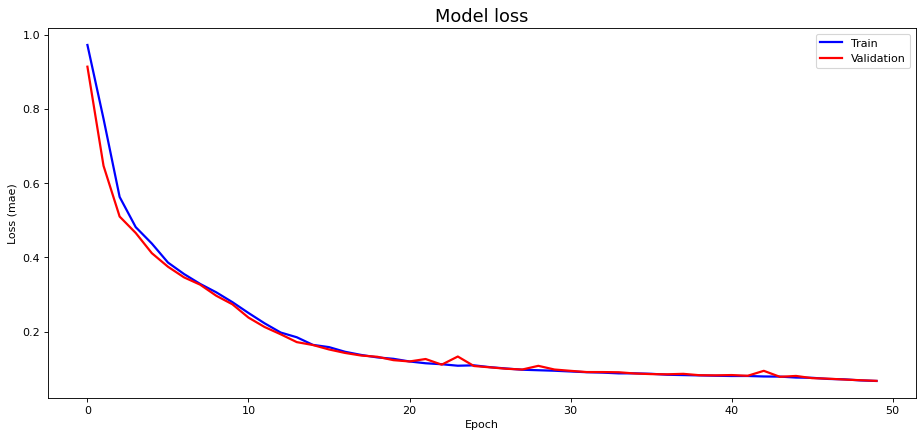

In [16]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

## Detección de anomalías

Para detectar las anomalías sobre el conjunto de Test, debemos reconstruir las entradas de Test y calcular el error  entre la predicción y los datos reales. Presuponemos que las secuencias con errores más altos tienen algo (anomalías) que las hace diferentes y que no  permite reconstruirlas correctamente.






16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


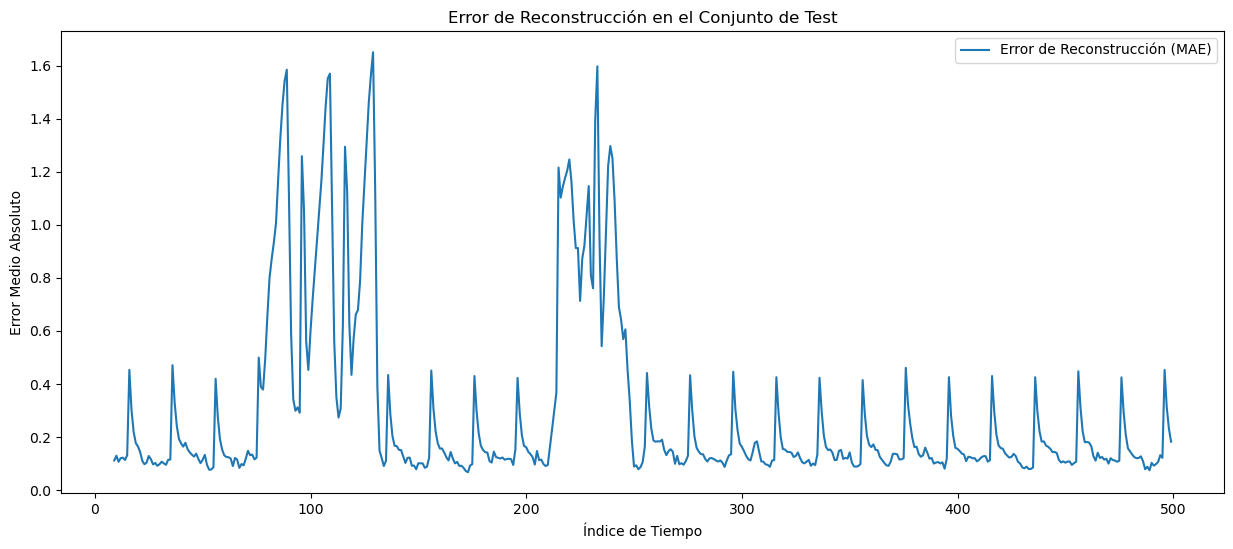

In [26]:
X_test_pred_seq = autoencoder.predict(X_test_seq)

# Calcula el error de reconstrucción (ej. MAE) para cada secuencia

reconstruction_errors = np.mean(np.abs(X_test_seq - X_test_pred_seq), axis=(1,2)) # MAE por secuencia

# Para alinear los errores con el dataframe original, necesitamos tener en cuenta el window_size
# El error de reconstrucción para la secuencia que TERMINA en el tiempo `t` se asocia con `t`.
df_test_analysis = testset.iloc[WINDOW_SIZE-1:].copy()
df_test_analysis['Reconstruction_Error'] = reconstruction_errors

plt.figure(figsize=(15, 6))
plt.plot(df_test_analysis.index, df_test_analysis['Reconstruction_Error'], label='Error de Reconstrucción (MAE)')
plt.title('Error de Reconstrucción en el Conjunto de Test')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Error Medio Absoluto')
plt.legend()
plt.show()

Umbral de anomalía establecido (MAE): 0.8712


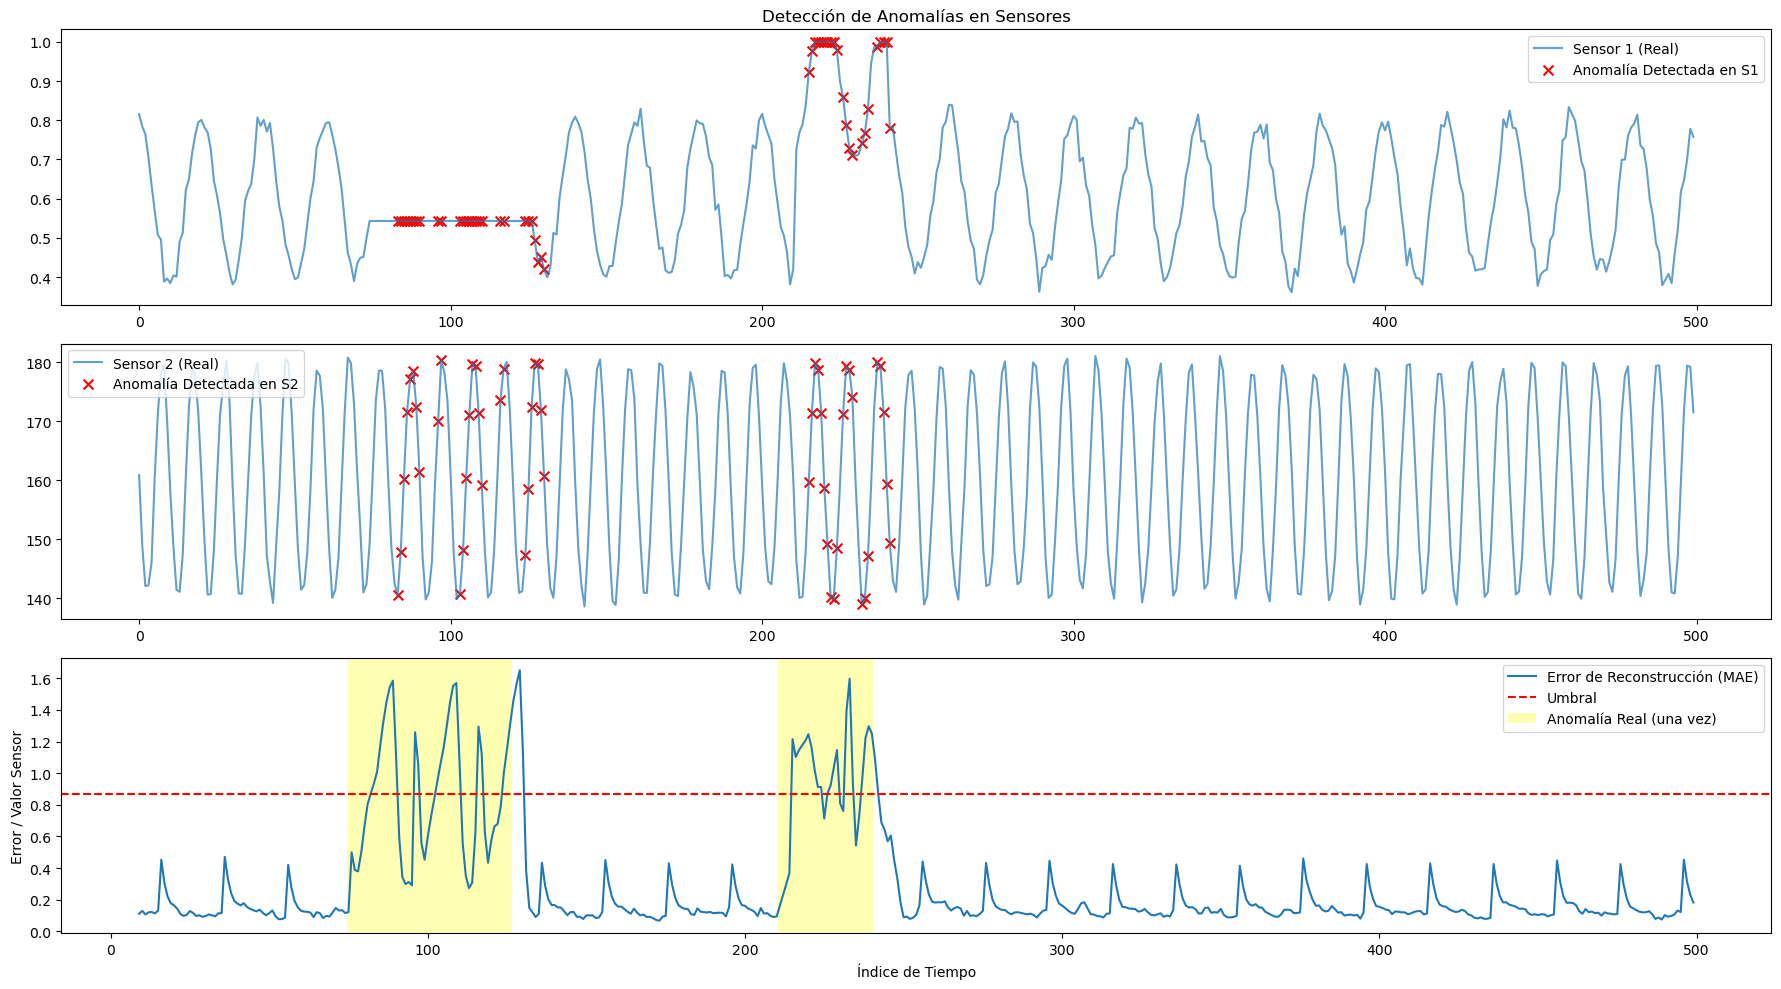

In [28]:
# Umbral simple: basado en un percentil del error de reconstrucción en los datos de test
UMBRAL_ANOMALIA = np.percentile(reconstruction_errors, 90) # Ej: 90º percentil como umbral
print(f"Umbral de anomalía establecido (MAE): {UMBRAL_ANOMALIA:.4f}")

df_test_analysis['Anomalia_Detectada'] = df_test_analysis['Reconstruction_Error'] > UMBRAL_ANOMALIA

# Visualizar detecciones
plt.figure(figsize=(18, 10))

plt.subplot(3,1,1)
plt.plot(testset.index, testset['Sensor1_HumedadEntrada'], label='Sensor 1 (Real)', alpha=0.7)
plt.scatter(df_test_analysis[df_test_analysis['Anomalia_Detectada']].index,
            testset.loc[df_test_analysis[df_test_analysis['Anomalia_Detectada']].index, 'Sensor1_HumedadEntrada'],
            color='red', label='Anomalía Detectada en S1', marker='x', s=50)
plt.title('Detección de Anomalías en Sensores')
plt.legend()

plt.subplot(3,1,2)
plt.plot(testset.index, testset['Sensor2_TemperaturaGases'], label='Sensor 2 (Real)', alpha=0.7)
plt.scatter(df_test_analysis[df_test_analysis['Anomalia_Detectada']].index,
            testset.loc[df_test_analysis[df_test_analysis['Anomalia_Detectada']].index, 'Sensor2_TemperaturaGases'],
            color='red', label='Anomalía Detectada en S2', marker='x', s=50)
plt.legend()

plt.subplot(3,1,3)
plt.plot(df_test_analysis.index, df_test_analysis['Reconstruction_Error'], label='Error de Reconstrucción (MAE)')
plt.axhline(UMBRAL_ANOMALIA, color='r', linestyle='--', label='Umbral')
# Marcar las anomalías reales para comparación visual
true_anomalies_indices = testset[testset['Es_Anomalia']].index
# Filtrar los que están dentro del rango de df_test_analysis
true_anomalies_in_analysis = [idx for idx in true_anomalies_indices if idx in df_test_analysis.index]

for idx in true_anomalies_in_analysis:
    if df_test_analysis.loc[idx, 'Es_Anomalia']:
         plt.axvspan(idx - 0.5, idx + 0.5, color='yellow', alpha=0.3, lw=0, label='Anomalía Real (una vez)' if 'Anomalía Real (una vez)' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel('Índice de Tiempo')
plt.ylabel('Error / Valor Sensor')
plt.legend()
plt.tight_layout()
plt.show()

## Reconstrucción de los datos

Teniendo en cuenta lo que el *autoencoder* reconstruye dadas unas observaciones anómalas, podemos tratar de analizar cómo deberían ser los datos del sensor "estropeado" para que las secuencias pudiesen recontruirse. 


**Nota**: *esta parte es solo informativa y deben analizarse los resultados con mucha prudencia.  Esta aproximación es simplista y puede tener sentido solo si las anomalías están en un solo sensor. No vamos a conseguir los datos correctos pero se pueden acercar más a la realidad que lo medido erroneamente por el sensor.*

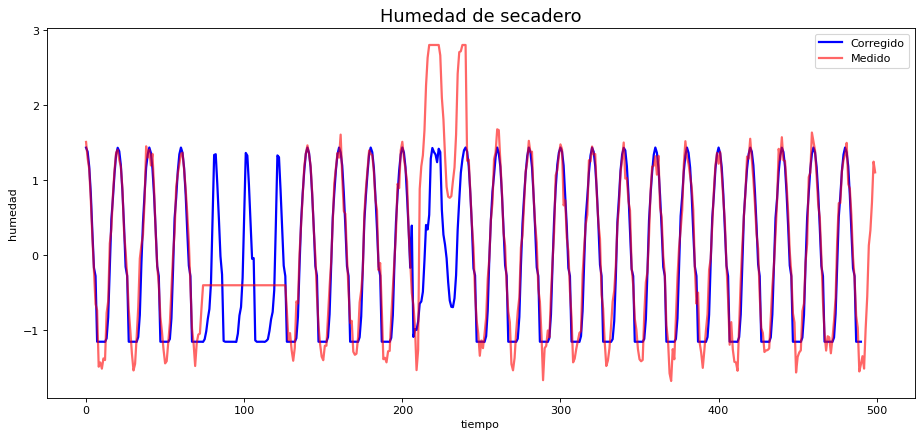

In [29]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(X_test_pred_seq[:,0,0].flatten(), 'b', label='Corregido', linewidth=2)
ax.plot(scaled_testset["Sensor1_HumedadEntrada"], 'r', label='Medido', linewidth=2, alpha=0.6)
ax.set_title('Humedad de secadero', fontsize=16)
ax.set_ylabel('humedad')
ax.set_xlabel('tiempo')
ax.legend(loc='upper right')
plt.show()